In [1]:
import pickle
import math
import random

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import imp
import functions

from joblib import Parallel, delayed
from sklearn.manifold import TSNE
import datetime as dt
def padInput(input):
    max_length = np.max([len(i) for i in input])
    input_size = len(input)
    input_pad = np.zeros((input_size, max_length))
    
    for idx_row, row in enumerate(input):
        for idx_col, col in enumerate(row):
            input_pad[idx_row][idx_col]=col
            
    return input_pad

karate_club = [[2, 1],
[3, 1], [3, 2],
[4, 1], [4, 2], [4, 3],
[5, 1],
[6, 1],
[7, 1], [7, 5], [7, 6],
[8, 1], [8, 2], [8, 3], [8, 4],
[9, 1], [9, 3],
[10, 3],
[11, 1], [11, 5], [11, 6],
[12, 1],
[13, 1], [13, 4],
[14, 1], [14, 2], [14, 3], [14, 4],
[17, 6], [17, 7],
[18, 1], [18, 2],
[20, 1], [20, 2],
[22, 1], [22, 2],
[26, 24], [26, 25],
[28, 3], [28, 24], [28, 25],
[29, 3],
[30, 24], [30, 27],
[31, 2], [31, 9],
[32, 1], [32, 25], [32, 26], [32, 29],
[33, 3], [33, 9], [33, 15], [33, 16], [33, 19], [33, 21], [33, 23], [33, 24], [33, 30], [33, 31], [33, 32],
[34, 9], [34, 10], [34, 14], [34, 15], [34, 16], [34, 19], [34, 20], [34, 21], [34, 23], [34, 24], [34, 27],
               [34, 28], [34, 29], [34, 30], [34, 31], [34, 32], [34, 33],]

In [2]:
dummy_graph = [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], 
              [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6]]

In [3]:
karate_club = [[karate_club[idx][0]-1,karate_club[idx][1]-1] for idx in range(len(karate_club))]

In [4]:
#graph = pickle.load(open('backup/graph_root_sina.pkl', 'rb'))
#domains = pickle.load(open('backup/domains_root_sina.pkl', 'rb'))
graph_file = pickle.load(open('graph.pkl', 'rb'))
domains_file = pickle.load(open('domains.pkl', 'rb'))
#graph = karate_club
#graph = dummy_graph

In [8]:
unique_keys = set([])
for key in graph_file.keys():
    keys = [i for i in graph_file[key] if isinstance(i, dt.datetime)==False]
    
    unique_keys = unique_keys.union(keys)

unique_keys = unique_keys | set(graph_file.keys())

In [9]:
vocab_dict = {key:idx for idx, key in enumerate(unique_keys)}
inv_map = {values:keys for keys, values in vocab_dict.items()}

In [10]:
#web_graph = nx.DiGraph()
web_graph = nx.Graph()
for node in graph_file.keys():
    for idx in range(0, len(graph_file[node]), 2):
        key = graph_file[node][idx]
        #print (key)
        web_graph.add_edge(vocab_dict[node], vocab_dict[key])

In [11]:
list_of_nodes = [i for i in web_graph.nodes()]

In [12]:
#for connection in graph:
#    web_graph.add_edge(connection[0], connection[1])

In [13]:
plt.figure(figsize=(10, 10))
nx.draw(web_graph, node_size=100)#, with_labels=True)
plt.savefig('nytimes_root_graph_undirected.png')
#plt.show()

In [14]:
def randomWalk(graph, initial_node, step, max_step, path):
 
    if step>= max_step: 
        return path
    
    adjacent_nodes = [i for i in graph[initial_node]]
    
    next_node = random.sample(adjacent_nodes, 1)[0]
    
    path.append(next_node)
    
    return randomWalk(graph, next_node, step+1, max_step, path)

In [16]:
def generateBatchKuhan(batch_size, num_context_per_label, context_window, target, step):

    batch = []
    passes_through_batch = batch_size//num_context_per_label
    
    for window_idx in range(passes_through_batch): #double / gives you a integer

        current_window = list(context_window[window_idx + passes_through_batch*step])
        current_target = target[window_idx + passes_through_batch*step]
        context_samples = random.sample(current_window, num_context_per_label)
        data_samples =  [[context_sample, [current_target]] for context_sample in context_samples]

        for data_sample in data_samples:
            batch.append(data_sample)
            
    return batch

In [54]:
max_step = 2 #Window size and max_step must be connected

num_skips = 1 #The number of context examples per label to create x-y data out of 
#i.e. the number of rows of "data" per window, label combo
window_size = max_step//2 #where max step must be even
embedding_size = 32  # Dimension of the embedding vector.
vocabulary_size = len(web_graph.nodes())

num_sampled = 16# Number of negative examples to sample. 
#As this number goes to the total number of samples it reproduces softmax
batch_size = 64 #must be a multiple of num_skips
num_steps = int(len(list_of_nodes)/batch_size)
n_epochs = 10000 #This controls the number of walks from each node

In [55]:
print (len(list_of_nodes), num_steps), vocabulary_size

1988 31


(None, 1988)

In [56]:
tf.reset_default_graph()
graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

    # Ops and variables pinned to the CPU because of missing GPU implementation
    #with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm

In [57]:
#For sanity checking
#batch_inputs = [2, 2, 0, 0, 13, 15, 7, 8, 9, 10, 11, 14, 6, 6, 1, 1]
#batch_labels = [[3], [3], [13], [0], [15], [11], [15], [13], [14], [2], [7], [8], [3], [3], [3], [3]]

In [58]:
avg_loss_record = []
list_batch_labels = []
list_batch_inputs = []

with tf.Session(graph=graph) as session:

    # We must initialize all variables before we use them.
    session.run(tf.global_variables_initializer())
    print('Initialized')

    average_loss = 0

    for epoch in range(n_epochs):
        #Conduct shuffle the list of nodes at the start of each epoch
        random.shuffle(list_of_nodes)
        random_walks = []
        
        for node in list_of_nodes:
            #Step through each node and conduct a random walk about it of length max_step
            path = randomWalk(web_graph, node, 0, max_step, [node])
            random_walks.append(path)
        
        data_windows = np.array(random_walks)

        target = data_windows[:,window_size]

        left_window = data_windows[:,:window_size]

        right_window = data_windows[:,window_size+1:]

        context_window = np.concatenate([left_window, right_window], axis=1)
            
        for step in range(num_steps):
        #for step in range(16):

            batch_data = generateBatchKuhan(batch_size, num_skips, context_window, target, step)
            batch_inputs = [row[0] for row in batch_data]
            batch_labels = [row[1] for row in batch_data]
            
            #batch_inputs = [row for row in range(batch_size)]
            #batch_labels = [[row] for row in range(batch_size)]
            #print (batch_inputs, batch_labels)
            
            feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
            list_batch_labels.append([batch_labels])
            list_batch_inputs.append([batch_inputs])
            
            _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
            
            average_loss += loss_val
            
            #if step%15==0:
            #    print (step, loss_val, num_steps)

        #if epoch!=0: average_loss /= num_steps #This is the averaged over the steps, this means data is passed through only once?
        #I think because num_steps> length of data, we must recycle through the data set
        #but each time data is randomly generated, because we are using different context words

        if epoch%1==0: 
            
            avg_loss_record.append(float(average_loss)/num_steps)
            print('epoch:%d, Average loss:%.7g' % (epoch, float(average_loss)/num_steps))
        
        average_loss = 0

        final_embeddings = normalized_embeddings.eval()

Initialized
Average loss  54.74543
Average loss  52.2969
Average loss  50.37405
Average loss  46.3544
Average loss  47.91276
Average loss  44.65188
Average loss  45.88854
Average loss  47.24989
Average loss  42.39029
Average loss  43.31625
Average loss  45.2943
Average loss  42.4295
Average loss  43.76366
Average loss  41.56176
Average loss  41.17057
Average loss  39.7947
Average loss  40.56129
Average loss  38.89
Average loss  37.08526
Average loss  37.593
Average loss  39.67322
Average loss  36.86906
Average loss  37.50535
Average loss  36.86336
Average loss  37.55464
Average loss  35.08941
Average loss  36.6891
Average loss  36.09697
Average loss  35.90866
Average loss  33.8008
Average loss  35.33913
Average loss  33.90293
Average loss  35.6599
Average loss  35.58067
Average loss  31.08286
Average loss  33.88994
Average loss  36.73631
Average loss  31.61829
Average loss  33.87785
Average loss  33.09364
Average loss  35.18837
Average loss  33.97595
Average loss  33.89867
Average loss

Average loss  7.771069
Average loss  8.443749
Average loss  8.583021
Average loss  7.329551
Average loss  6.674425
Average loss  8.050763
Average loss  8.372087
Average loss  7.748501
Average loss  7.771206
Average loss  8.692358
Average loss  8.210991
Average loss  6.777907
Average loss  8.290242
Average loss  7.176381
Average loss  7.185715
Average loss  7.257298
Average loss  7.188064
Average loss  7.063332
Average loss  7.508015
Average loss  7.916778
Average loss  6.776563
Average loss  8.446629
Average loss  5.56421
Average loss  6.990422
Average loss  6.358167
Average loss  7.547796
Average loss  7.352229
Average loss  7.2567
Average loss  6.804508
Average loss  6.032919
Average loss  7.499318
Average loss  6.550596
Average loss  6.331731
Average loss  6.154287
Average loss  5.91292
Average loss  7.188439
Average loss  5.81603
Average loss  5.294682
Average loss  5.390863
Average loss  5.318897
Average loss  6.180092
Average loss  5.829396
Average loss  7.17298
Average loss  7.3

Average loss  1.277907
Average loss  1.095984
Average loss  1.016769
Average loss  1.130213
Average loss  0.9238915
Average loss  1.150858
Average loss  1.00677
Average loss  1.005378
Average loss  1.087123
Average loss  0.9345612
Average loss  1.077813
Average loss  1.108239
Average loss  1.268784
Average loss  1.242813
Average loss  1.005248
Average loss  0.9999614
Average loss  1.110612
Average loss  1.192234
Average loss  1.09622
Average loss  1.046676
Average loss  0.9521887
Average loss  1.099786
Average loss  1.341667
Average loss  1.034449
Average loss  0.9234331
Average loss  1.213868
Average loss  0.9687356
Average loss  1.020709
Average loss  1.209436
Average loss  1.184537
Average loss  1.140857
Average loss  1.00971
Average loss  1.224293
Average loss  1.16936
Average loss  1.469276
Average loss  1.024537
Average loss  1.205659
Average loss  0.9335266
Average loss  1.123523
Average loss  0.9329213
Average loss  1.119177
Average loss  1.143061
Average loss  1.277128
Average

Average loss  0.7214025
Average loss  0.7440334
Average loss  0.9133712
Average loss  0.8282137
Average loss  0.6945152
Average loss  0.6527643
Average loss  0.9455649
Average loss  0.6636074
Average loss  0.8904418
Average loss  0.7456847
Average loss  0.9540778
Average loss  0.8100395
Average loss  0.8322653
Average loss  1.043466
Average loss  0.7662592
Average loss  0.6923008
Average loss  0.8656596
Average loss  0.8479256
Average loss  0.696989
Average loss  0.6420772
Average loss  0.620023
Average loss  0.5689887
Average loss  0.6060802
Average loss  0.6940679
Average loss  0.6153822
Average loss  0.6223805
Average loss  0.701228
Average loss  0.8008738
Average loss  1.047349
Average loss  0.6791612
Average loss  0.7595733
Average loss  0.7589089
Average loss  0.8033754
Average loss  0.662254
Average loss  0.7394395
Average loss  0.828897
Average loss  0.9372841
Average loss  0.7073918
Average loss  0.6564291
Average loss  0.9131817
Average loss  0.8358689
Average loss  0.6296759

Average loss  0.4583686
Average loss  0.6748858
Average loss  0.5948111
Average loss  0.5572898
Average loss  0.5047138
Average loss  0.7283046
Average loss  0.650792
Average loss  0.5556092
Average loss  0.6440202
Average loss  0.5947548
Average loss  0.6049846
Average loss  0.6458362
Average loss  0.7232627
Average loss  0.5096012
Average loss  0.4388193
Average loss  0.5531845
Average loss  0.7977047
Average loss  0.5369289
Average loss  0.5564837
Average loss  0.568388
Average loss  0.6399384
Average loss  0.5986376
Average loss  0.5623762
Average loss  0.4501352
Average loss  0.4873733
Average loss  0.5863072
Average loss  0.5959686
Average loss  0.7737291
Average loss  0.7360737
Average loss  0.5514271
Average loss  0.629015
Average loss  0.8271906
Average loss  0.6298119
Average loss  0.4928874
Average loss  0.6117786
Average loss  0.8459647
Average loss  0.5123966
Average loss  0.7267048
Average loss  0.5380176
Average loss  0.4678487
Average loss  0.523925
Average loss  0.6967

Average loss  0.3794392
Average loss  0.6717194
Average loss  0.3769369
Average loss  0.4068062
Average loss  0.4944785
Average loss  0.4075714
Average loss  0.3974893
Average loss  0.4102542
Average loss  0.4346523
Average loss  0.4750333
Average loss  0.3944883
Average loss  0.3605535
Average loss  0.54944
Average loss  0.5007698
Average loss  0.5544852
Average loss  0.3971438
Average loss  0.369543
Average loss  0.3707583
Average loss  0.4483858
Average loss  0.3764417
Average loss  0.4731879
Average loss  0.5952146
Average loss  0.399684
Average loss  0.3486981
Average loss  0.4223138
Average loss  0.4464646
Average loss  0.428874
Average loss  0.4882618
Average loss  0.4258416
Average loss  0.4395664
Average loss  0.3553393
Average loss  0.3788111
Average loss  0.5518514
Average loss  0.3475746
Average loss  0.387306
Average loss  0.4487871
Average loss  0.619572
Average loss  0.3372942
Average loss  0.3693135
Average loss  0.5609809
Average loss  0.444238
Average loss  0.3674927


Average loss  0.3219682
Average loss  0.3117611
Average loss  0.3747298
Average loss  0.4642264
Average loss  0.3397442
Average loss  0.3279711
Average loss  0.315512
Average loss  0.3636748
Average loss  0.3184025
Average loss  0.3884187
Average loss  0.3612819
Average loss  0.3488602
Average loss  0.3449393
Average loss  0.4946119
Average loss  0.4813543
Average loss  0.3482581
Average loss  0.2857042
Average loss  0.3192071
Average loss  0.3445749
Average loss  0.3304811
Average loss  0.3138397
Average loss  0.280495
Average loss  0.3804306
Average loss  0.37947
Average loss  0.3440943
Average loss  0.3987441
Average loss  0.2907714
Average loss  0.4700879
Average loss  0.3740264
Average loss  0.3389699
Average loss  0.3466429
Average loss  0.4096774
Average loss  0.3515076
Average loss  0.3029186
Average loss  0.3889899
Average loss  0.4087216
Average loss  0.3231961
Average loss  0.2818276
Average loss  0.2997475
Average loss  0.4713552
Average loss  0.3585637
Average loss  0.3191

Average loss  0.2760029
Average loss  0.3648889
Average loss  0.4555501
Average loss  0.2820345
Average loss  0.4954865
Average loss  0.272813
Average loss  0.2950718
Average loss  0.3597294
Average loss  0.4061391
Average loss  0.2814867
Average loss  0.3282146
Average loss  0.4474548
Average loss  0.3374322
Average loss  0.3357998
Average loss  0.4066976
Average loss  0.3598615
Average loss  0.2571002
Average loss  0.4476927
Average loss  0.3119094
Average loss  0.2840896
Average loss  0.3126303
Average loss  0.3809969
Average loss  0.3157096
Average loss  0.3160665
Average loss  0.4142889
Average loss  0.3184843
Average loss  0.3076502
Average loss  0.2713056
Average loss  0.3069761
Average loss  0.3409134
Average loss  0.3554404
Average loss  0.2676592
Average loss  0.3198174
Average loss  0.3092778
Average loss  0.2958512
Average loss  0.3495732
Average loss  0.2452022
Average loss  0.462373
Average loss  0.3223204
Average loss  0.3195886
Average loss  0.384941
Average loss  0.242

Average loss  0.3520061
Average loss  0.2642094
Average loss  0.4158469
Average loss  0.2293371
Average loss  0.2997015
Average loss  0.2407368
Average loss  0.2913456
Average loss  0.2856664
Average loss  0.4987527
Average loss  0.3170456
Average loss  0.2389442
Average loss  0.3167694
Average loss  0.2618192
Average loss  0.257727
Average loss  0.4144788
Average loss  0.4636646
Average loss  0.3195654
Average loss  0.3920793
Average loss  0.4342448
Average loss  0.3461515
Average loss  0.2749093
Average loss  0.2376839
Average loss  0.2456905
Average loss  0.4529918
Average loss  0.3528857
Average loss  0.2485629
Average loss  0.2470412
Average loss  0.2689091
Average loss  0.2730396
Average loss  0.2952677
Average loss  0.2395152
Average loss  0.2019643
Average loss  0.2998526
Average loss  0.3264962
Average loss  0.2466312
Average loss  0.3473728
Average loss  0.2296941
Average loss  0.3357575
Average loss  0.2588393
Average loss  0.2995499
Average loss  0.2036319
Average loss  0.2

Average loss  0.294522
Average loss  0.2607211
Average loss  0.2871318
Average loss  0.2593932
Average loss  0.2568874
Average loss  0.2132298
Average loss  0.1979897
Average loss  0.4626614
Average loss  0.2603775
Average loss  0.2488506
Average loss  0.2635389
Average loss  0.2939191
Average loss  0.2095988
Average loss  0.1969357
Average loss  0.3690631
Average loss  0.2300063
Average loss  0.2317734
Average loss  0.22335
Average loss  0.2678816
Average loss  0.4056883
Average loss  0.218995
Average loss  0.3130861
Average loss  0.2379253
Average loss  0.3553717
Average loss  0.2945656
Average loss  0.2634202
Average loss  0.3221739
Average loss  0.2439406
Average loss  0.2284424
Average loss  0.2642434
Average loss  0.2617749
Average loss  0.2705271
Average loss  0.3118379
Average loss  0.2332449
Average loss  0.3050048
Average loss  0.2167949
Average loss  0.3328637
Average loss  0.3341693
Average loss  0.3188688
Average loss  0.2579952
Average loss  0.5161661
Average loss  0.2378

Average loss  0.2209908
Average loss  0.2005102
Average loss  0.2847264
Average loss  0.2596598
Average loss  0.3283907
Average loss  0.2479322
Average loss  0.3122672
Average loss  0.2284399
Average loss  0.3525312
Average loss  0.2842123
Average loss  0.2868342
Average loss  0.2714123
Average loss  0.2810599
Average loss  0.2991302
Average loss  0.2878534
Average loss  0.2886454
Average loss  0.2034518
Average loss  0.2838764
Average loss  0.2749076
Average loss  0.2779827
Average loss  0.2461585
Average loss  0.281643
Average loss  0.2569759
Average loss  0.2125685
Average loss  0.2022365
Average loss  0.2109181
Average loss  0.2094403
Average loss  0.2588022
Average loss  0.3152815
Average loss  0.2360024
Average loss  0.2381504
Average loss  0.2722272
Average loss  0.3228596
Average loss  0.2770908
Average loss  0.2045964
Average loss  0.1768372
Average loss  0.2125015
Average loss  0.2768758
Average loss  0.2443739
Average loss  0.2309073
Average loss  0.1827791
Average loss  0.2

Average loss  0.20581
Average loss  0.1957135
Average loss  0.2071094
Average loss  0.3747722
Average loss  0.1721861
Average loss  0.213435
Average loss  0.3676877
Average loss  0.2231291
Average loss  0.2664968
Average loss  0.2082451
Average loss  0.2249043
Average loss  0.1697096
Average loss  0.2063278
Average loss  0.3043568
Average loss  0.1794461
Average loss  0.2990131
Average loss  0.1686267
Average loss  0.2626564
Average loss  0.2070216
Average loss  0.1854616
Average loss  0.1743244
Average loss  0.1910598
Average loss  0.2768855
Average loss  0.190723
Average loss  0.1634241
Average loss  0.2938585
Average loss  0.1921251
Average loss  0.1971986
Average loss  0.3041625
Average loss  0.2929657
Average loss  0.201793
Average loss  0.3334951
Average loss  0.1798121
Average loss  0.2255618
Average loss  0.2204457
Average loss  0.1857779
Average loss  0.2037218
Average loss  0.2405608
Average loss  0.3015693
Average loss  0.170579
Average loss  0.2075495
Average loss  0.169874

Average loss  0.1672493
Average loss  0.2580005
Average loss  0.2415024
Average loss  0.1704821
Average loss  0.3327603
Average loss  0.1647901
Average loss  0.2053405
Average loss  0.1625536
Average loss  0.2229835
Average loss  0.2393162
Average loss  0.3195144
Average loss  0.2668412
Average loss  0.1722798
Average loss  0.2740497
Average loss  0.2392578
Average loss  0.1853656
Average loss  0.1787113
Average loss  0.2189247
Average loss  0.1774529
Average loss  0.1754115
Average loss  0.1714801
Average loss  0.1624826
Average loss  0.1562248
Average loss  0.385451
Average loss  0.1612317
Average loss  0.2506125
Average loss  0.1849463
Average loss  0.1918025
Average loss  0.1958618
Average loss  0.1698992
Average loss  0.168797
Average loss  0.2655416
Average loss  0.1617796
Average loss  0.1933645
Average loss  0.3212591
Average loss  0.1772959
Average loss  0.2795563
Average loss  0.1694218
Average loss  0.1642164
Average loss  0.1556802
Average loss  0.1695046
Average loss  0.19

Average loss  0.1674911
Average loss  0.1976526
Average loss  0.1974067
Average loss  0.2243161
Average loss  0.2479168
Average loss  0.1612361
Average loss  0.2167301
Average loss  0.1692043
Average loss  0.1949723
Average loss  0.2951606
Average loss  0.1720948
Average loss  0.1690114
Average loss  0.2542718
Average loss  0.2742028
Average loss  0.183529
Average loss  0.3394703
Average loss  0.1661719
Average loss  0.2192074
Average loss  0.1752967
Average loss  0.2003313
Average loss  0.1627291
Average loss  0.1581646
Average loss  0.3052336
Average loss  0.1975175
Average loss  0.1510277
Average loss  0.1896211
Average loss  0.1911899
Average loss  0.1686792
Average loss  0.1335369
Average loss  0.2168878
Average loss  0.1768374
Average loss  0.1445943
Average loss  0.1697112
Average loss  0.1873898
Average loss  0.2582759
Average loss  0.2116343
Average loss  0.2503415
Average loss  0.1722911
Average loss  0.1849347
Average loss  0.2311404
Average loss  0.1694008
Average loss  0.2

Average loss  0.1638885
Average loss  0.1643521
Average loss  0.1525592
Average loss  0.1653787
Average loss  0.1972581
Average loss  0.1304134
Average loss  0.1515024
Average loss  0.3932428
Average loss  0.2243303
Average loss  0.1856183
Average loss  0.1884757
Average loss  0.1756907
Average loss  0.1877103
Average loss  0.2436107
Average loss  0.1261403
Average loss  0.1753489
Average loss  0.1717959
Average loss  0.1754588
Average loss  0.2524307
Average loss  0.1563136
Average loss  0.2302662
Average loss  0.240558
Average loss  0.1440495
Average loss  0.1138528
Average loss  0.1642028
Average loss  0.2197284
Average loss  0.2007971
Average loss  0.1572126
Average loss  0.2039651
Average loss  0.1543572
Average loss  0.1938337
Average loss  0.1630587
Average loss  0.1635597
Average loss  0.1634787
Average loss  0.208174
Average loss  0.1914778
Average loss  0.1766259
Average loss  0.2352036
Average loss  0.3420106
Average loss  0.1531677
Average loss  0.1783702
Average loss  0.15

Average loss  0.1975201
Average loss  0.1568045
Average loss  0.1171784
Average loss  0.1723118
Average loss  0.2270662
Average loss  0.1390244
Average loss  0.2343035
Average loss  0.1421762
Average loss  0.196442
Average loss  0.1561759
Average loss  0.1623329
Average loss  0.1989793
Average loss  0.2374399
Average loss  0.2060665
Average loss  0.1515913
Average loss  0.1717289
Average loss  0.1310539
Average loss  0.1538605
Average loss  0.1411643
Average loss  0.147203
Average loss  0.1926222
Average loss  0.1815581
Average loss  0.200475
Average loss  0.1455925
Average loss  0.1308317
Average loss  0.3645592
Average loss  0.23792
Average loss  0.1919962
Average loss  0.1337658
Average loss  0.1267513
Average loss  0.2765689
Average loss  0.1452929
Average loss  0.2174413
Average loss  0.1748606
Average loss  0.1328775
Average loss  0.1654232
Average loss  0.1705298
Average loss  0.1507602
Average loss  0.1840177
Average loss  0.1522832
Average loss  0.2193089
Average loss  0.23021

KeyboardInterrupt: 

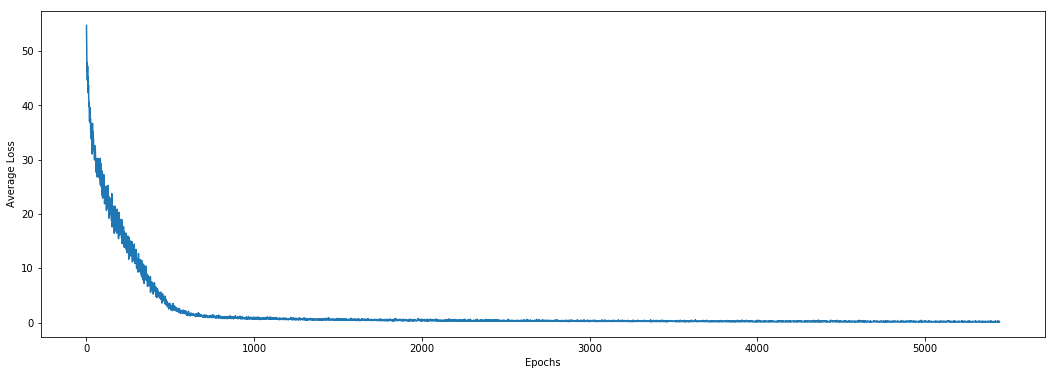

In [59]:
list_loss = np.array(avg_loss_record)
plt.figure(figsize=(18, 6))
plt.plot([i for i in range(len(list_loss))], list_loss)
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.show()

In [60]:
#tf.reset_default_graph()

In [61]:
vector = tf.placeholder(dtype=tf.float32)
#Create similarity matrix
mult_vector = tf.matmul(vector, vector, transpose_b=True)
sim_matrix = tf.acos(mult_vector)

In [62]:
with tf.Session() as sess:
    matrices = sess.run([sim_matrix, mult_vector] , feed_dict={vector:final_embeddings})

In [63]:
sim_matrix = matrices[0]

In [64]:
sim_matrix = np.array([[value if value==value else 0 for value in row] for row in sim_matrix])

In [65]:
np.fill_diagonal(sim_matrix, 0)

In [66]:
#Similarity is based  on the batch inputs not on the batch labels!
#This is important
#batch_inputs

In [67]:
results = []
for idx_row, row in enumerate(sim_matrix):
    #print (row)
    top_n_scores = [row[i] for i in np.argsort(row)[:2]]
    top_n_nodes = [i for i in np.argsort(row)[:2]]
    results.append([top_n_scores[1], top_n_nodes[1]])

In [68]:
results = np.array(results)

In [69]:
np.argsort(results[:,0])

array([1672, 1599,  695, ...,  521, 1547, 1938], dtype=int64)

In [70]:
results[1672]

array([  5.06228507e-01,   1.59900000e+03])

In [92]:
sim = sim_matrix[8]

top_n_scores = [sim[i] for i in np.argsort(sim)[:5]]
top_n_nodes = [i for i in np.argsort(sim)[:5]]

bottom_n_scores = [sim[i] for i in np.argsort(sim)[-5:]]
bottom_n_nodes = [i for i in np.argsort(sim)[-5:]]

top_n_scores, top_n_nodes, bottom_n_scores, bottom_n_nodes

([0.0,
  0.69698750972747803,
  0.75766736268997192,
  0.77033066749572754,
  0.77499836683273315],
 [8, 1348, 181, 506, 1526],
 [1.5325596332550049,
  1.5371468067169189,
  1.5440001487731934,
  1.5727385282516479,
  1.6211618185043335],
 [854, 984, 1754, 1687, 455])

In [93]:
sim = sim_matrix[1670]

top_n_scores = [sim[i] for i in np.argsort(sim)[:5]]
top_n_nodes = [i for i in np.argsort(sim)[:5]]

bottom_n_scores = [sim[i] for i in np.argsort(sim)[-5:]]
bottom_n_nodes = [i for i in np.argsort(sim)[-5:]]

top_n_scores, top_n_nodes, bottom_n_scores, bottom_n_nodes

([0.0,
  0.74942821264266968,
  0.77965331077575684,
  0.77987837791442871,
  0.79354214668273926],
 [1670, 683, 1401, 1941, 642],
 [1.6037107706069946,
  1.6287198066711426,
  1.6358891725540161,
  1.6816208362579346,
  1.7215356826782227],
 [1052, 1008, 1819, 946, 1918])

In [88]:
vocab_dict['https://support.google.com/a/answer/60217'], vocab_dict['https://support.google.com/a/answer/48323']

(8, 1670)

In [86]:
web_graph[vocab_dict['https://support.google.com/a/answer/60217']], \
web_graph[vocab_dict['https://support.google.com/a/answer/48323']]

(AtlasView({1519: {}}), AtlasView({1519: {}}))

In [83]:
[i for i in vocab_dict if 'support.google.com' in i]

['https://support.google.com/a/answer/60217',
 'https://support.google.com/mail/3394215',
 'https://support.google.com/a/topic/1409901',
 'http://support.google.com/groups/bin/answer.py?answer=46601',
 'https://support.google.com/a/table/3247295',
 'https://support.google.com/accounts/troubleshooter/2402620?#ts=2402553',
 'https://support.google.com/docs?hl=en&p=#topic=2811805',
 'https://support.google.com/a/answer/60233',
 'https://support.google.com/plus/?hl=en_US',
 'https://support.google.com/a/',
 'https://support.google.com/a/#topic=29157',
 'https://support.google.com/a/answer/48323',
 'https://support.google.com']

In [74]:
[inv_map[i] for i in top_n_nodes]

['https://blog.twitter.com/official/pt_br.html',
 'https://developer.twitter.com/en/docs/ads/audiences/api-reference/insights',
 'https://cloud.google.com/spanner/docs/instances#available_configurations',
 'http://www.census.gov/topics/housing/housing-patterns.html',
 'https://careers.twitter.com/en/locations/boston.html']

In [75]:
[web_graph[i] for i in top_n_nodes]

[AtlasView({1747: {}}),
 AtlasView({291: {}}),
 AtlasView({239: {}}),
 AtlasView({513: {}}),
 AtlasView({780: {}})]

In [262]:
top_n_node_connections = [set([q for q in web_graph[i]]) for i in top_n_nodes]
bottom_n_node_connections = [set([q for q in web_graph[i]]) for i in bottom_n_nodes]

In [276]:
#top_n_node_connections, bottom_n_node_connections

In [264]:
[top_n_node_connections[0] & nodes for nodes in top_n_node_connections]

[{8284}, set(), set(), set(), set()]

In [265]:
[top_n_node_connections[0] & nodes for nodes in bottom_n_node_connections]

[set(), set(), set(), set(), set()]

In [ ]:
learning_grid = [50]
perplexity_grid = [15, 50, 100]

for learning_rate in learning_grid:
    for perplexity in perplexity_grid:
        tsne = TSNE(perplexity=perplexity, n_components=2, learning_rate=learning_rate, n_iter=40000, 
                    verbose=9, metric='precomputed')
        
        low_dim_embs = tsne.fit_transform(sim_matrix)
        pickle.dump(low_dim_embs, open('low_dim_embs_grid_%d_%d.pkl' % (learning_rate, perplexity), 'wb'))

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 8787 samples in 0.110s...
[t-SNE] Computed neighbors for 8787 samples in 1.062s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8787
[t-SNE] Computed conditional probabilities for sample 2000 / 8787
[t-SNE] Computed conditional probabilities for sample 3000 / 8787
[t-SNE] Computed conditional probabilities for sample 4000 / 8787
[t-SNE] Computed conditional probabilities for sample 5000 / 8787
[t-SNE] Computed conditional probabilities for sample 6000 / 8787
[t-SNE] Computed conditional probabilities for sample 7000 / 8787
[t-SNE] Computed conditional probabilities for sample 8000 / 8787
[t-SNE] Computed conditional probabilities for sample 8787 / 8787
[t-SNE] Mean sigma: 0.137131
[t-SNE] Computed conditional probabilities in 0.087s
[t-SNE] Iteration 50: error = 117.1727524, gradient norm = 0.0000060 (50 iterations in 9.654s)
[t-SNE] Iteration 100: error = 117.1727524, gradient norm = 0.0000009 (50 iterations in 

[t-SNE] Iteration 3900: error = 3.8956449, gradient norm = 0.0002550 (50 iterations in 7.461s)
[t-SNE] Iteration 3950: error = 3.8845007, gradient norm = 0.0002507 (50 iterations in 7.347s)
[t-SNE] Iteration 4000: error = 3.8736463, gradient norm = 0.0002469 (50 iterations in 7.328s)
[t-SNE] Iteration 4050: error = 3.8629663, gradient norm = 0.0002433 (50 iterations in 7.344s)
[t-SNE] Iteration 4100: error = 3.8525050, gradient norm = 0.0002389 (50 iterations in 7.316s)
[t-SNE] Iteration 4150: error = 3.8423023, gradient norm = 0.0002352 (50 iterations in 7.431s)
[t-SNE] Iteration 4200: error = 3.8322508, gradient norm = 0.0002317 (50 iterations in 7.356s)
[t-SNE] Iteration 4250: error = 3.8224325, gradient norm = 0.0002275 (50 iterations in 7.365s)
[t-SNE] Iteration 4300: error = 3.8128300, gradient norm = 0.0002235 (50 iterations in 7.424s)
[t-SNE] Iteration 4350: error = 3.8034039, gradient norm = 0.0002196 (50 iterations in 7.349s)
[t-SNE] Iteration 4400: error = 3.7941463, gradien

[t-SNE] Iteration 8250: error = 3.3991363, gradient norm = 0.0000994 (50 iterations in 7.619s)
[t-SNE] Iteration 8300: error = 3.3964980, gradient norm = 0.0000986 (50 iterations in 7.519s)
[t-SNE] Iteration 8350: error = 3.3938680, gradient norm = 0.0000981 (50 iterations in 7.519s)
[t-SNE] Iteration 8400: error = 3.3912876, gradient norm = 0.0000978 (50 iterations in 7.641s)
[t-SNE] Iteration 8450: error = 3.3887374, gradient norm = 0.0000968 (50 iterations in 7.638s)
[t-SNE] Iteration 8500: error = 3.3862224, gradient norm = 0.0000964 (50 iterations in 7.591s)
[t-SNE] Iteration 8550: error = 3.3837657, gradient norm = 0.0000954 (50 iterations in 7.543s)
[t-SNE] Iteration 8600: error = 3.3812790, gradient norm = 0.0000946 (50 iterations in 7.547s)
[t-SNE] Iteration 8650: error = 3.3788855, gradient norm = 0.0000943 (50 iterations in 7.666s)
[t-SNE] Iteration 8700: error = 3.3764710, gradient norm = 0.0000934 (50 iterations in 7.537s)
[t-SNE] Iteration 8750: error = 3.3741331, gradien

[t-SNE] Iteration 12550: error = 3.2719760, gradient norm = 0.0000799 (50 iterations in 7.940s)
[t-SNE] Iteration 12600: error = 3.2713523, gradient norm = 0.0000797 (50 iterations in 7.618s)
[t-SNE] Iteration 12650: error = 3.2707038, gradient norm = 0.0000797 (50 iterations in 7.690s)
[t-SNE] Iteration 12700: error = 3.2701087, gradient norm = 0.0000794 (50 iterations in 7.728s)
[t-SNE] Iteration 12750: error = 3.2695007, gradient norm = 0.0000783 (50 iterations in 7.712s)
[t-SNE] Iteration 12800: error = 3.2688911, gradient norm = 0.0000792 (50 iterations in 7.605s)
[t-SNE] Iteration 12850: error = 3.2683072, gradient norm = 0.0000788 (50 iterations in 7.648s)
[t-SNE] Iteration 12900: error = 3.2676973, gradient norm = 0.0000790 (50 iterations in 7.751s)
[t-SNE] Iteration 12950: error = 3.2671158, gradient norm = 0.0000787 (50 iterations in 7.812s)
[t-SNE] Iteration 13000: error = 3.2665269, gradient norm = 0.0000781 (50 iterations in 7.779s)
[t-SNE] Iteration 13050: error = 3.26600

[t-SNE] Iteration 16850: error = 3.2364736, gradient norm = 0.0000673 (50 iterations in 8.088s)
[t-SNE] Iteration 16900: error = 3.2361643, gradient norm = 0.0000671 (50 iterations in 7.926s)
[t-SNE] Iteration 16950: error = 3.2358658, gradient norm = 0.0000664 (50 iterations in 8.117s)
[t-SNE] Iteration 17000: error = 3.2355721, gradient norm = 0.0000661 (50 iterations in 8.014s)
[t-SNE] Iteration 17050: error = 3.2352669, gradient norm = 0.0000658 (50 iterations in 8.049s)
[t-SNE] Iteration 17100: error = 3.2349787, gradient norm = 0.0000660 (50 iterations in 7.979s)
[t-SNE] Iteration 17150: error = 3.2346799, gradient norm = 0.0000661 (50 iterations in 8.094s)
[t-SNE] Iteration 17200: error = 3.2343633, gradient norm = 0.0000667 (50 iterations in 8.051s)
[t-SNE] Iteration 17250: error = 3.2340488, gradient norm = 0.0000664 (50 iterations in 8.018s)
[t-SNE] Iteration 17300: error = 3.2337174, gradient norm = 0.0000664 (50 iterations in 7.987s)
[t-SNE] Iteration 17350: error = 3.23339

[t-SNE] Iteration 21150: error = 3.2125504, gradient norm = 0.0000586 (50 iterations in 8.168s)
[t-SNE] Iteration 21200: error = 3.2123430, gradient norm = 0.0000590 (50 iterations in 8.182s)
[t-SNE] Iteration 21250: error = 3.2120864, gradient norm = 0.0000584 (50 iterations in 8.281s)
[t-SNE] Iteration 21300: error = 3.2118492, gradient norm = 0.0000575 (50 iterations in 8.229s)
[t-SNE] Iteration 21350: error = 3.2115984, gradient norm = 0.0000575 (50 iterations in 8.252s)
[t-SNE] Iteration 21400: error = 3.2113781, gradient norm = 0.0000579 (50 iterations in 8.227s)
[t-SNE] Iteration 21450: error = 3.2111320, gradient norm = 0.0000576 (50 iterations in 8.179s)
[t-SNE] Iteration 21500: error = 3.2108972, gradient norm = 0.0000577 (50 iterations in 8.240s)
[t-SNE] Iteration 21550: error = 3.2106380, gradient norm = 0.0000581 (50 iterations in 8.324s)
[t-SNE] Iteration 21600: error = 3.2104080, gradient norm = 0.0000581 (50 iterations in 8.266s)
[t-SNE] Iteration 21650: error = 3.21015

[t-SNE] Iteration 25450: error = 3.1919930, gradient norm = 0.0000533 (50 iterations in 8.372s)
[t-SNE] Iteration 25500: error = 3.1917691, gradient norm = 0.0000536 (50 iterations in 8.360s)
[t-SNE] Iteration 25550: error = 3.1915596, gradient norm = 0.0000533 (50 iterations in 8.342s)
[t-SNE] Iteration 25600: error = 3.1913421, gradient norm = 0.0000529 (50 iterations in 8.359s)
[t-SNE] Iteration 25650: error = 3.1911309, gradient norm = 0.0000522 (50 iterations in 8.286s)
[t-SNE] Iteration 25700: error = 3.1909482, gradient norm = 0.0000530 (50 iterations in 8.421s)
[t-SNE] Iteration 25750: error = 3.1907313, gradient norm = 0.0000527 (50 iterations in 8.377s)
[t-SNE] Iteration 25800: error = 3.1905200, gradient norm = 0.0000527 (50 iterations in 8.396s)
[t-SNE] Iteration 25850: error = 3.1903353, gradient norm = 0.0000523 (50 iterations in 8.394s)
[t-SNE] Iteration 25900: error = 3.1901305, gradient norm = 0.0000521 (50 iterations in 8.291s)
[t-SNE] Iteration 25950: error = 3.18990

[t-SNE] Iteration 29750: error = 3.1757207, gradient norm = 0.0000491 (50 iterations in 8.387s)
[t-SNE] Iteration 29800: error = 3.1755106, gradient norm = 0.0000489 (50 iterations in 8.421s)
[t-SNE] Iteration 29850: error = 3.1753485, gradient norm = 0.0000487 (50 iterations in 8.380s)
[t-SNE] Iteration 29900: error = 3.1751819, gradient norm = 0.0000488 (50 iterations in 8.422s)
[t-SNE] Iteration 29950: error = 3.1749761, gradient norm = 0.0000490 (50 iterations in 8.586s)
[t-SNE] Iteration 30000: error = 3.1747856, gradient norm = 0.0000491 (50 iterations in 8.544s)
[t-SNE] Iteration 30050: error = 3.1746273, gradient norm = 0.0000486 (50 iterations in 8.447s)
[t-SNE] Iteration 30100: error = 3.1744690, gradient norm = 0.0000485 (50 iterations in 8.452s)
[t-SNE] Iteration 30150: error = 3.1743228, gradient norm = 0.0000489 (50 iterations in 8.772s)
[t-SNE] Iteration 30200: error = 3.1741347, gradient norm = 0.0000488 (50 iterations in 8.990s)
[t-SNE] Iteration 30250: error = 3.17398

[t-SNE] Iteration 34050: error = 3.1645982, gradient norm = 0.0000446 (50 iterations in 8.491s)
[t-SNE] Iteration 34100: error = 3.1644893, gradient norm = 0.0000446 (50 iterations in 8.597s)
[t-SNE] Iteration 34150: error = 3.1643972, gradient norm = 0.0000441 (50 iterations in 8.673s)
[t-SNE] Iteration 34200: error = 3.1642954, gradient norm = 0.0000446 (50 iterations in 8.654s)
[t-SNE] Iteration 34250: error = 3.1642118, gradient norm = 0.0000441 (50 iterations in 8.912s)
[t-SNE] Iteration 34300: error = 3.1640916, gradient norm = 0.0000443 (50 iterations in 8.620s)
[t-SNE] Iteration 34350: error = 3.1639452, gradient norm = 0.0000440 (50 iterations in 8.525s)
[t-SNE] Iteration 34400: error = 3.1638598, gradient norm = 0.0000439 (50 iterations in 8.569s)
[t-SNE] Iteration 34450: error = 3.1637678, gradient norm = 0.0000438 (50 iterations in 8.594s)
[t-SNE] Iteration 34500: error = 3.1636679, gradient norm = 0.0000445 (50 iterations in 8.481s)
[t-SNE] Iteration 34550: error = 3.16354

[t-SNE] Iteration 38350: error = 3.1548972, gradient norm = 0.0000425 (50 iterations in 8.710s)
[t-SNE] Iteration 38400: error = 3.1547947, gradient norm = 0.0000427 (50 iterations in 8.717s)
[t-SNE] Iteration 38450: error = 3.1547070, gradient norm = 0.0000423 (50 iterations in 8.648s)
[t-SNE] Iteration 38500: error = 3.1545908, gradient norm = 0.0000421 (50 iterations in 8.821s)
[t-SNE] Iteration 38550: error = 3.1544659, gradient norm = 0.0000420 (50 iterations in 8.682s)
[t-SNE] Iteration 38600: error = 3.1543541, gradient norm = 0.0000426 (50 iterations in 8.808s)
[t-SNE] Iteration 38650: error = 3.1542635, gradient norm = 0.0000428 (50 iterations in 8.684s)
[t-SNE] Iteration 38700: error = 3.1541507, gradient norm = 0.0000428 (50 iterations in 8.719s)
[t-SNE] Iteration 38750: error = 3.1540346, gradient norm = 0.0000421 (50 iterations in 8.739s)
[t-SNE] Iteration 38800: error = 3.1539190, gradient norm = 0.0000417 (50 iterations in 8.606s)
[t-SNE] Iteration 38850: error = 3.15381

[t-SNE] Iteration 700: error = 4.7676992, gradient norm = 0.0007393 (50 iterations in 7.636s)
[t-SNE] Iteration 750: error = 4.6586680, gradient norm = 0.0006612 (50 iterations in 7.685s)
[t-SNE] Iteration 800: error = 4.5618210, gradient norm = 0.0005965 (50 iterations in 7.595s)
[t-SNE] Iteration 850: error = 4.4750600, gradient norm = 0.0005414 (50 iterations in 7.605s)
[t-SNE] Iteration 900: error = 4.3963633, gradient norm = 0.0004958 (50 iterations in 7.443s)
[t-SNE] Iteration 950: error = 4.3246274, gradient norm = 0.0004540 (50 iterations in 7.619s)
[t-SNE] Iteration 1000: error = 4.2592893, gradient norm = 0.0004191 (50 iterations in 7.492s)
[t-SNE] Iteration 1050: error = 4.1989503, gradient norm = 0.0003894 (50 iterations in 7.439s)
[t-SNE] Iteration 1100: error = 4.1435676, gradient norm = 0.0003612 (50 iterations in 7.433s)
[t-SNE] Iteration 1150: error = 4.0924244, gradient norm = 0.0003390 (50 iterations in 7.438s)
[t-SNE] Iteration 1200: error = 4.0451922, gradient norm

[t-SNE] Iteration 5050: error = 3.2295449, gradient norm = 0.0000649 (50 iterations in 7.692s)
[t-SNE] Iteration 5100: error = 3.2283597, gradient norm = 0.0000643 (50 iterations in 7.704s)
[t-SNE] Iteration 5150: error = 3.2272794, gradient norm = 0.0000655 (50 iterations in 7.679s)
[t-SNE] Iteration 5200: error = 3.2261560, gradient norm = 0.0000673 (50 iterations in 7.697s)
[t-SNE] Iteration 5250: error = 3.2251723, gradient norm = 0.0000650 (50 iterations in 7.665s)
[t-SNE] Iteration 5300: error = 3.2241988, gradient norm = 0.0000632 (50 iterations in 7.728s)
[t-SNE] Iteration 5350: error = 3.2232924, gradient norm = 0.0000632 (50 iterations in 7.762s)
[t-SNE] Iteration 5400: error = 3.2223780, gradient norm = 0.0000632 (50 iterations in 7.745s)
[t-SNE] Iteration 5450: error = 3.2215214, gradient norm = 0.0000616 (50 iterations in 7.732s)
[t-SNE] Iteration 5500: error = 3.2206547, gradient norm = 0.0000617 (50 iterations in 7.860s)
[t-SNE] Iteration 5550: error = 3.2198534, gradien

[t-SNE] Iteration 9400: error = 3.1783404, gradient norm = 0.0000490 (50 iterations in 7.933s)
[t-SNE] Iteration 9450: error = 3.1778805, gradient norm = 0.0000492 (50 iterations in 7.928s)
[t-SNE] Iteration 9500: error = 3.1774726, gradient norm = 0.0000488 (50 iterations in 7.992s)
[t-SNE] Iteration 9550: error = 3.1770620, gradient norm = 0.0000486 (50 iterations in 7.899s)
[t-SNE] Iteration 9600: error = 3.1766524, gradient norm = 0.0000485 (50 iterations in 7.900s)
[t-SNE] Iteration 9650: error = 3.1762853, gradient norm = 0.0000480 (50 iterations in 7.938s)
[t-SNE] Iteration 9700: error = 3.1758740, gradient norm = 0.0000489 (50 iterations in 8.037s)
[t-SNE] Iteration 9750: error = 3.1754653, gradient norm = 0.0000484 (50 iterations in 7.899s)
[t-SNE] Iteration 9800: error = 3.1750934, gradient norm = 0.0000490 (50 iterations in 7.991s)
[t-SNE] Iteration 9850: error = 3.1746728, gradient norm = 0.0000484 (50 iterations in 7.995s)
[t-SNE] Iteration 9900: error = 3.1743021, gradien

[t-SNE] Iteration 13700: error = 3.1518435, gradient norm = 0.0000421 (50 iterations in 8.057s)
[t-SNE] Iteration 13750: error = 3.1515968, gradient norm = 0.0000420 (50 iterations in 8.098s)
[t-SNE] Iteration 13800: error = 3.1514001, gradient norm = 0.0000412 (50 iterations in 8.041s)
[t-SNE] Iteration 13850: error = 3.1511583, gradient norm = 0.0000404 (50 iterations in 8.164s)
[t-SNE] Iteration 13900: error = 3.1509366, gradient norm = 0.0000407 (50 iterations in 8.046s)
[t-SNE] Iteration 13950: error = 3.1507244, gradient norm = 0.0000412 (50 iterations in 8.196s)
[t-SNE] Iteration 14000: error = 3.1504986, gradient norm = 0.0000417 (50 iterations in 8.191s)
[t-SNE] Iteration 14050: error = 3.1502793, gradient norm = 0.0000407 (50 iterations in 8.140s)
[t-SNE] Iteration 14100: error = 3.1500759, gradient norm = 0.0000404 (50 iterations in 8.125s)
[t-SNE] Iteration 14150: error = 3.1498303, gradient norm = 0.0000402 (50 iterations in 8.126s)
[t-SNE] Iteration 14200: error = 3.14960

[t-SNE] Iteration 18000: error = 3.1299534, gradient norm = 0.0000368 (50 iterations in 8.279s)
[t-SNE] Iteration 18050: error = 3.1297758, gradient norm = 0.0000366 (50 iterations in 8.229s)
[t-SNE] Iteration 18100: error = 3.1296198, gradient norm = 0.0000373 (50 iterations in 8.051s)
[t-SNE] Iteration 18150: error = 3.1294272, gradient norm = 0.0000371 (50 iterations in 8.232s)
[t-SNE] Iteration 18200: error = 3.1292624, gradient norm = 0.0000362 (50 iterations in 8.222s)
[t-SNE] Iteration 18250: error = 3.1291077, gradient norm = 0.0000371 (50 iterations in 8.060s)
[t-SNE] Iteration 18300: error = 3.1289580, gradient norm = 0.0000367 (50 iterations in 8.280s)
[t-SNE] Iteration 18350: error = 3.1287568, gradient norm = 0.0000366 (50 iterations in 8.272s)
[t-SNE] Iteration 18400: error = 3.1286371, gradient norm = 0.0000367 (50 iterations in 8.328s)
[t-SNE] Iteration 18450: error = 3.1284959, gradient norm = 0.0000372 (50 iterations in 8.133s)
[t-SNE] Iteration 18500: error = 3.12837

[t-SNE] Iteration 22300: error = 3.1189864, gradient norm = 0.0000343 (50 iterations in 8.241s)
[t-SNE] Iteration 22350: error = 3.1188736, gradient norm = 0.0000349 (50 iterations in 8.279s)
[t-SNE] Iteration 22400: error = 3.1187506, gradient norm = 0.0000348 (50 iterations in 8.313s)
[t-SNE] Iteration 22450: error = 3.1186342, gradient norm = 0.0000357 (50 iterations in 8.256s)
[t-SNE] Iteration 22500: error = 3.1185708, gradient norm = 0.0000346 (50 iterations in 8.214s)
[t-SNE] Iteration 22550: error = 3.1184893, gradient norm = 0.0000333 (50 iterations in 8.243s)
[t-SNE] Iteration 22600: error = 3.1183867, gradient norm = 0.0000345 (50 iterations in 8.162s)
[t-SNE] Iteration 22650: error = 3.1182644, gradient norm = 0.0000345 (50 iterations in 8.151s)
[t-SNE] Iteration 22700: error = 3.1182048, gradient norm = 0.0000344 (50 iterations in 8.367s)
[t-SNE] Iteration 22750: error = 3.1180859, gradient norm = 0.0000347 (50 iterations in 8.255s)
[t-SNE] Iteration 22800: error = 3.11799

[t-SNE] Iteration 26600: error = 3.1107230, gradient norm = 0.0000322 (50 iterations in 8.101s)
[t-SNE] Iteration 26650: error = 3.1106000, gradient norm = 0.0000321 (50 iterations in 8.122s)
[t-SNE] Iteration 26700: error = 3.1104994, gradient norm = 0.0000336 (50 iterations in 8.043s)
[t-SNE] Iteration 26750: error = 3.1104112, gradient norm = 0.0000321 (50 iterations in 8.092s)
[t-SNE] Iteration 26800: error = 3.1103663, gradient norm = 0.0000322 (50 iterations in 8.164s)
[t-SNE] Iteration 26850: error = 3.1102195, gradient norm = 0.0000335 (50 iterations in 8.054s)
[t-SNE] Iteration 26900: error = 3.1101658, gradient norm = 0.0000338 (50 iterations in 8.075s)
[t-SNE] Iteration 26950: error = 3.1100721, gradient norm = 0.0000326 (50 iterations in 8.078s)
[t-SNE] Iteration 27000: error = 3.1100094, gradient norm = 0.0000321 (50 iterations in 8.064s)
[t-SNE] Iteration 27050: error = 3.1098948, gradient norm = 0.0000331 (50 iterations in 8.114s)
[t-SNE] Iteration 27100: error = 3.10980

[t-SNE] Iteration 30900: error = 3.1037686, gradient norm = 0.0000322 (50 iterations in 7.954s)
[t-SNE] Iteration 30950: error = 3.1036758, gradient norm = 0.0000315 (50 iterations in 7.942s)
[t-SNE] Iteration 31000: error = 3.1035774, gradient norm = 0.0000329 (50 iterations in 7.906s)
[t-SNE] Iteration 31050: error = 3.1035850, gradient norm = 0.0000317 (50 iterations in 7.889s)
[t-SNE] Iteration 31100: error = 3.1035407, gradient norm = 0.0000313 (50 iterations in 7.937s)
[t-SNE] Iteration 31150: error = 3.1034575, gradient norm = 0.0000306 (50 iterations in 7.904s)
[t-SNE] Iteration 31200: error = 3.1033494, gradient norm = 0.0000321 (50 iterations in 7.999s)
[t-SNE] Iteration 31250: error = 3.1032472, gradient norm = 0.0000339 (50 iterations in 7.931s)
[t-SNE] Iteration 31300: error = 3.1031945, gradient norm = 0.0000331 (50 iterations in 7.963s)
[t-SNE] Iteration 31350: error = 3.1031303, gradient norm = 0.0000320 (50 iterations in 7.921s)
[t-SNE] Iteration 31400: error = 3.10304

[t-SNE] Iteration 35200: error = 3.0990310, gradient norm = 0.0000313 (50 iterations in 7.928s)
[t-SNE] Iteration 35250: error = 3.0989790, gradient norm = 0.0000320 (50 iterations in 7.930s)
[t-SNE] Iteration 35300: error = 3.0989437, gradient norm = 0.0000331 (50 iterations in 8.010s)
[t-SNE] Iteration 35350: error = 3.0988748, gradient norm = 0.0000333 (50 iterations in 7.962s)
[t-SNE] Iteration 35400: error = 3.0988808, gradient norm = 0.0000340 (50 iterations in 7.985s)
[t-SNE] Iteration 35450: error = 3.0987930, gradient norm = 0.0000321 (50 iterations in 7.886s)
[t-SNE] Iteration 35500: error = 3.0987742, gradient norm = 0.0000328 (50 iterations in 7.916s)
[t-SNE] Iteration 35550: error = 3.0987213, gradient norm = 0.0000323 (50 iterations in 7.963s)
[t-SNE] Iteration 35600: error = 3.0987222, gradient norm = 0.0000314 (50 iterations in 7.908s)
[t-SNE] Iteration 35650: error = 3.0986631, gradient norm = 0.0000313 (50 iterations in 7.865s)
[t-SNE] Iteration 35700: error = 3.09858

[t-SNE] Iteration 39500: error = 3.0951898, gradient norm = 0.0000288 (50 iterations in 7.947s)
[t-SNE] Iteration 39550: error = 3.0950847, gradient norm = 0.0000318 (50 iterations in 8.080s)
[t-SNE] Iteration 39600: error = 3.0950296, gradient norm = 0.0000338 (50 iterations in 8.042s)
[t-SNE] Iteration 39650: error = 3.0949836, gradient norm = 0.0000300 (50 iterations in 8.038s)
[t-SNE] Iteration 39700: error = 3.0949233, gradient norm = 0.0000311 (50 iterations in 7.899s)
[t-SNE] Iteration 39750: error = 3.0948565, gradient norm = 0.0000307 (50 iterations in 8.024s)
[t-SNE] Iteration 39800: error = 3.0947943, gradient norm = 0.0000319 (50 iterations in 8.104s)
[t-SNE] Iteration 39850: error = 3.0947208, gradient norm = 0.0000310 (50 iterations in 8.108s)
[t-SNE] Iteration 39900: error = 3.0947239, gradient norm = 0.0000298 (50 iterations in 8.025s)
[t-SNE] Iteration 39950: error = 3.0946138, gradient norm = 0.0000309 (50 iterations in 7.895s)
[t-SNE] Iteration 40000: error = 3.09455

[t-SNE] Iteration 2050: error = 3.2871432, gradient norm = 0.0000664 (50 iterations in 7.726s)
[t-SNE] Iteration 2100: error = 3.2813427, gradient norm = 0.0000662 (50 iterations in 7.792s)
[t-SNE] Iteration 2150: error = 3.2759945, gradient norm = 0.0000653 (50 iterations in 7.855s)
[t-SNE] Iteration 2200: error = 3.2710388, gradient norm = 0.0000635 (50 iterations in 7.859s)
[t-SNE] Iteration 2250: error = 3.2664566, gradient norm = 0.0000631 (50 iterations in 7.853s)
[t-SNE] Iteration 2300: error = 3.2621455, gradient norm = 0.0000634 (50 iterations in 7.830s)
[t-SNE] Iteration 2350: error = 3.2582037, gradient norm = 0.0000627 (50 iterations in 7.927s)
[t-SNE] Iteration 2400: error = 3.2545211, gradient norm = 0.0000617 (50 iterations in 7.946s)
[t-SNE] Iteration 2450: error = 3.2510898, gradient norm = 0.0000612 (50 iterations in 7.794s)
[t-SNE] Iteration 2500: error = 3.2478950, gradient norm = 0.0000612 (50 iterations in 7.800s)
[t-SNE] Iteration 2550: error = 3.2449868, gradien

[t-SNE] Iteration 6400: error = 3.1538031, gradient norm = 0.0000365 (50 iterations in 8.704s)
[t-SNE] Iteration 6450: error = 3.1531677, gradient norm = 0.0000359 (50 iterations in 8.681s)
[t-SNE] Iteration 6500: error = 3.1525395, gradient norm = 0.0000360 (50 iterations in 8.702s)
[t-SNE] Iteration 6550: error = 3.1519208, gradient norm = 0.0000363 (50 iterations in 8.712s)
[t-SNE] Iteration 6600: error = 3.1513064, gradient norm = 0.0000368 (50 iterations in 8.650s)
[t-SNE] Iteration 6650: error = 3.1506772, gradient norm = 0.0000356 (50 iterations in 8.644s)
[t-SNE] Iteration 6700: error = 3.1500762, gradient norm = 0.0000349 (50 iterations in 8.765s)
[t-SNE] Iteration 6750: error = 3.1494799, gradient norm = 0.0000343 (50 iterations in 8.770s)
[t-SNE] Iteration 6800: error = 3.1489077, gradient norm = 0.0000350 (50 iterations in 8.730s)
[t-SNE] Iteration 6850: error = 3.1483021, gradient norm = 0.0000352 (50 iterations in 8.795s)
[t-SNE] Iteration 6900: error = 3.1477263, gradien

[t-SNE] Iteration 10750: error = 3.1168065, gradient norm = 0.0000268 (50 iterations in 9.243s)
[t-SNE] Iteration 10800: error = 3.1164963, gradient norm = 0.0000270 (50 iterations in 9.346s)
[t-SNE] Iteration 10850: error = 3.1162038, gradient norm = 0.0000291 (50 iterations in 9.349s)
[t-SNE] Iteration 10900: error = 3.1159244, gradient norm = 0.0000290 (50 iterations in 9.496s)
[t-SNE] Iteration 10950: error = 3.1156292, gradient norm = 0.0000281 (50 iterations in 9.404s)
[t-SNE] Iteration 11000: error = 3.1154048, gradient norm = 0.0000276 (50 iterations in 9.271s)
[t-SNE] Iteration 11050: error = 3.1151242, gradient norm = 0.0000269 (50 iterations in 9.373s)
[t-SNE] Iteration 11100: error = 3.1148803, gradient norm = 0.0000286 (50 iterations in 9.394s)
[t-SNE] Iteration 11150: error = 3.1146524, gradient norm = 0.0000267 (50 iterations in 9.527s)
[t-SNE] Iteration 11200: error = 3.1144142, gradient norm = 0.0000260 (50 iterations in 9.596s)
[t-SNE] Iteration 11250: error = 3.11416

[t-SNE] Iteration 15050: error = 3.0993273, gradient norm = 0.0000224 (50 iterations in 9.902s)
[t-SNE] Iteration 15100: error = 3.0991333, gradient norm = 0.0000227 (50 iterations in 9.960s)
[t-SNE] Iteration 15150: error = 3.0989621, gradient norm = 0.0000232 (50 iterations in 10.006s)
[t-SNE] Iteration 15200: error = 3.0987928, gradient norm = 0.0000225 (50 iterations in 10.090s)
[t-SNE] Iteration 15250: error = 3.0986328, gradient norm = 0.0000225 (50 iterations in 10.068s)
[t-SNE] Iteration 15300: error = 3.0984578, gradient norm = 0.0000224 (50 iterations in 9.961s)
[t-SNE] Iteration 15350: error = 3.0982804, gradient norm = 0.0000210 (50 iterations in 9.990s)
[t-SNE] Iteration 15400: error = 3.0981624, gradient norm = 0.0000215 (50 iterations in 9.935s)
[t-SNE] Iteration 15450: error = 3.0979846, gradient norm = 0.0000225 (50 iterations in 10.166s)
[t-SNE] Iteration 15500: error = 3.0978248, gradient norm = 0.0000207 (50 iterations in 10.086s)
[t-SNE] Iteration 15550: error = 3.

[t-SNE] Iteration 19300: error = 3.0872369, gradient norm = 0.0000177 (50 iterations in 10.690s)
[t-SNE] Iteration 19350: error = 3.0871110, gradient norm = 0.0000196 (50 iterations in 10.740s)
[t-SNE] Iteration 19400: error = 3.0870404, gradient norm = 0.0000180 (50 iterations in 10.716s)
[t-SNE] Iteration 19450: error = 3.0869446, gradient norm = 0.0000175 (50 iterations in 10.821s)
[t-SNE] Iteration 19500: error = 3.0868294, gradient norm = 0.0000201 (50 iterations in 10.690s)
[t-SNE] Iteration 19550: error = 3.0867271, gradient norm = 0.0000180 (50 iterations in 10.716s)
[t-SNE] Iteration 19600: error = 3.0866363, gradient norm = 0.0000182 (50 iterations in 10.725s)
[t-SNE] Iteration 19650: error = 3.0865567, gradient norm = 0.0000182 (50 iterations in 10.682s)
[t-SNE] Iteration 19700: error = 3.0864315, gradient norm = 0.0000194 (50 iterations in 10.745s)
[t-SNE] Iteration 19750: error = 3.0863240, gradient norm = 0.0000206 (50 iterations in 10.752s)
[t-SNE] Iteration 19800: error

In [285]:
tsne = TSNE(perplexity=10, n_components=2, learning_rate=1, n_iter=50000, verbose=9, metric='precomputed')
low_dim_embs = tsne.fit_transform(sim_matrix)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 8787 samples in 0.097s...
[t-SNE] Computed neighbors for 8787 samples in 1.014s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8787
[t-SNE] Computed conditional probabilities for sample 2000 / 8787
[t-SNE] Computed conditional probabilities for sample 3000 / 8787
[t-SNE] Computed conditional probabilities for sample 4000 / 8787
[t-SNE] Computed conditional probabilities for sample 5000 / 8787
[t-SNE] Computed conditional probabilities for sample 6000 / 8787
[t-SNE] Computed conditional probabilities for sample 7000 / 8787
[t-SNE] Computed conditional probabilities for sample 8000 / 8787
[t-SNE] Computed conditional probabilities for sample 8787 / 8787
[t-SNE] Mean sigma: 0.160281
[t-SNE] Computed conditional probabilities in 0.141s
[t-SNE] Iteration 50: error = 109.2683563, gradient norm = 0.0000058 (50 iterations in 11.066s)
[t-SNE] Iteration 100: error = 109.2683563, gradient norm = 0.0000004 (50 iterations in

[t-SNE] Iteration 3900: error = 4.3404908, gradient norm = 0.0002171 (50 iterations in 9.252s)
[t-SNE] Iteration 3950: error = 4.3324389, gradient norm = 0.0002132 (50 iterations in 9.290s)
[t-SNE] Iteration 4000: error = 4.3245025, gradient norm = 0.0002091 (50 iterations in 9.226s)
[t-SNE] Iteration 4050: error = 4.3167462, gradient norm = 0.0002054 (50 iterations in 9.159s)
[t-SNE] Iteration 4100: error = 4.3090367, gradient norm = 0.0002018 (50 iterations in 9.226s)
[t-SNE] Iteration 4150: error = 4.3015528, gradient norm = 0.0001984 (50 iterations in 9.200s)
[t-SNE] Iteration 4200: error = 4.2942495, gradient norm = 0.0001954 (50 iterations in 9.211s)
[t-SNE] Iteration 4250: error = 4.2870688, gradient norm = 0.0001923 (50 iterations in 9.234s)
[t-SNE] Iteration 4300: error = 4.2799435, gradient norm = 0.0001889 (50 iterations in 9.351s)
[t-SNE] Iteration 4350: error = 4.2730079, gradient norm = 0.0001862 (50 iterations in 9.096s)
[t-SNE] Iteration 4400: error = 4.2662263, gradien

[t-SNE] Iteration 8200: error = 3.9787662, gradient norm = 0.0000824 (50 iterations in 9.216s)


KeyboardInterrupt: 

In [242]:
#pickle.dump(low_dim_embs, open('low_dim_embs_karate_club.pkl', 'wb'))

In [8]:
%matplotlib notebook
import mpld3
from mpld3 import plugins
mpld3.enable_notebook()

In [10]:
labels = [i for i in range(0, len(web_graph.nodes()), 1)]

#pickle.dump(low_dim_embs, open('low_dim_embs.pkl', 'wb'))

#low_dim_embs = pickle.load(open('low_dim_embs_grid_1_5.pkl', 'rb'))

In [15]:
learning_grid = [1, 10, 50]
perplexity_grid = [5, 15, 50]
for learning_rate in learning_grid:
    for perplexity in perplexity_grid:
        low_dim_embs = pickle.load(open('low_dim_embs_grid_%d_%d.pkl' % (learning_rate, perplexity), 'rb'))
        
        fig, ax = plt.subplots()

        points = ax.plot(low_dim_embs[:,0], low_dim_embs[:,1], 'o', color='b',
                     mec='k', ms=5, mew=1, alpha=.6)
        fig.savefig('low_dim_embs_grid_%d_%d.png' % (learning_rate, perplexity))

#tooltip = plugins.PointHTMLTooltip(points[0], labels)

#plugins.connect(fig, tooltip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FileNotFoundError: [Errno 2] No such file or directory: 'low_dim_embs_grid_50_5.pkl'

In [12]:
#mpld3.display()

In [179]:
#plt.figure(figsize=(10, 10))
nx.draw_networkx(web_graph, with_labels=True, node_size=50, arrows=False)
plt.show()

In [46]:
results[14]

array([ 1.89316559,  0.92058927,  1.45331097,  1.20190859,  1.14429533,
        0.79873216,  0.58146346,  1.08515716,  1.04885304,  1.11311364,
        0.63541526,  1.38222861,  1.25472403,  1.53170264,  0.        ,
        1.09863055,  1.24171519,  1.49786341,  0.84771544,  1.76275682,
        0.74969655,  1.26779151,  1.00599658,  0.9319672 ,  1.20524192,
        0.97492516,  1.1583147 ,  1.49007535,  1.15756428,  1.15787256,
        0.83833277,  1.61629784,  1.09607387,  0.99879616], dtype=float32)

In [48]:
results[22]

array([ 2.12768841,  0.95966452,  1.16453874,  1.53453577,  1.35475671,
        1.25087941,  1.02873313,  1.10538161,  0.68419492,  1.37566459,
        1.03665698,  1.20357859,  1.51137674,  1.66352248,  1.00599658,
        0.91914564,  1.3249526 ,  1.60193515,  1.20680094,  1.49263489,
        0.93455303,  1.75604236,  0.        ,  0.92661941,  1.08651865,
        1.09799027,  1.3243686 ,  1.42965853,  1.64990151,  1.52092946,
        0.84679461,  1.43893862,  1.36679614,  1.29531991], dtype=float32)